D:\Jack station\pet\lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (68) exceeds the maximum length of 64 allowed for VR LO.
  warn_and_log(msg)
D:\Jack station\pet\lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (84) exceeds the maximum length of 64 allowed for VR LO.
  warn_and_log(msg)


Processed 50/1703
Processed 100/1703
Processed 150/1703
Processed 200/1703
Processed 250/1703
Processed 300/1703
Processed 350/1703
Processed 400/1703
Processed 450/1703
Processed 500/1703
Processed 550/1703
Processed 600/1703
Processed 650/1703
Processed 700/1703
Processed 750/1703
Processed 800/1703
Processed 850/1703
Processed 900/1703
Processed 950/1703
Processed 1000/1703
Processed 1050/1703
Processed 1100/1703
Processed 1150/1703
Processed 1200/1703
Processed 1250/1703
Processed 1300/1703
Processed 1350/1703
Processed 1400/1703
Processed 1450/1703
Processed 1500/1703
Processed 1550/1703
Processed 1600/1703
Processed 1650/1703
Processed 1700/1703
Processed 1703/1703

Done. DICOMs written under: D:\new data_back\PET_low_Combined_All

COV scaling check (background):
file	full	0.100	0.050	0.020	0.010	0.005
Real_small_animal_(Rat)_EnIm1_PET_Frame_33.dcm	0.7362	1.0786	1.2835	1.7997	2.3868	2.3513
Image_Quality_phantom_EnIm1_Frame_381.dcm	0.7108	0.9814	1.2929	1.9422	2.3061	2.7140
Real_sm

C:\Temp\ipykernel_6696\1135695608.py:264: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(); plt.show()


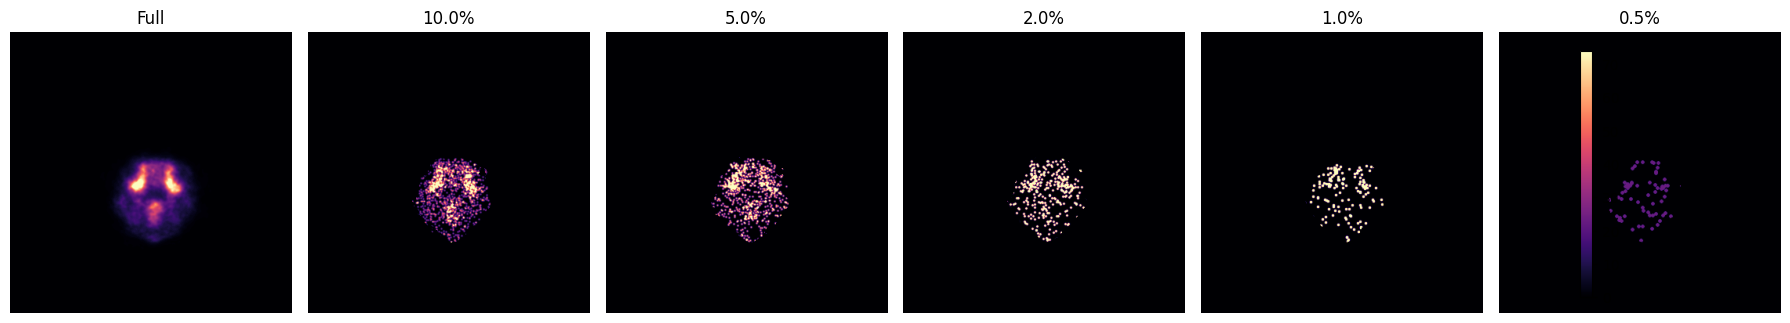

Viewing: Image_Quality_phantom_EnIm1_Frame_381.dcm


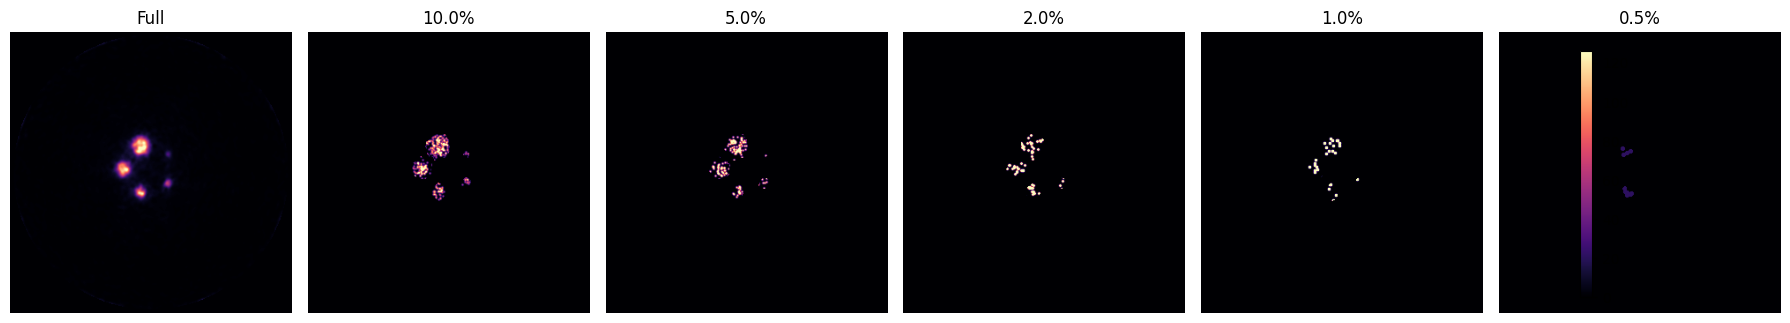

Viewing: Real_small_animal_(Rat)_EnIm1_PET_Frame_493.dcm


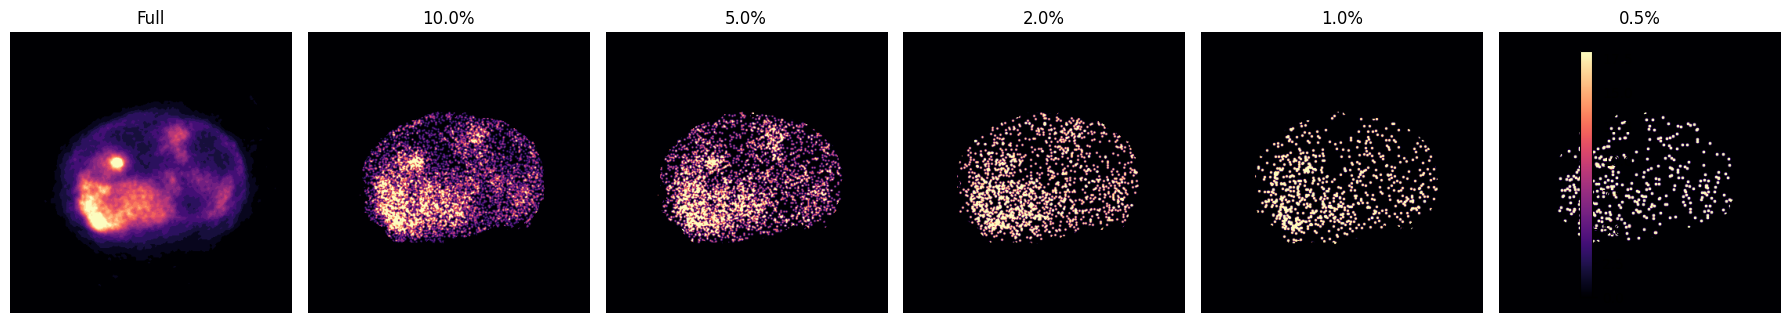

In [3]:
# Direct full-dose .dcm  ->  low-dose .dcm (Poisson thinning, background-safe writer)
# -----------------------------------------------------------------------------------
# pip install numpy pydicom scipy scikit-image matplotlib

from pathlib import Path
import numpy as np, math, random
import pydicom
from pydicom.uid import generate_uid
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, binary_fill_holes
from skimage.filters import threshold_otsu

# ==== EDIT THESE ====

INPUT_DIR   =  Path(r"D:\new data_back\PET_Combined_All")      # folder with your full-dose DICOM slices
OUTPUT_ROOT = Path(r"D:\new data_back\PET_low_Combined_All")    # where to write low-dose DICOMs
ALPHAS      = [0.10, 0.05, 0.02, 0.01, 0.005]            # 10%, 5%, 2%, 1%, 0.5%
SEED        = 2025
# Poisson options
ADD_CORR_GAUSS_SIGMA = 0.8   # 0 = off; 0.6–1.2 px adds mild OSEM-like correlation
PRE_DENOISE_SIGMA    = 0.0   # optional tiny pre-smoothing of full-dose before counts mapping
# Display/QC
PCTL_MAX   = 98.0
N_SHOW     = 3
VIEW_MODE  = "dose_normalized"  # "shared" | "per_image" | "dose_normalized"

# ===== Robust DICOM load (float) =====
def load_dicom_float(path: Path):
    ds = pydicom.dcmread(path, force=True)
    try:
        arr = ds.pixel_array.astype(np.float32)
    except Exception:
        rows, cols = int(ds.Rows), int(ds.Columns)
        bits = int(getattr(ds,"BitsAllocated",16) or 16)
        rep  = int(getattr(ds,"PixelRepresentation",0) or 0)
        dt   = np.uint16 if (bits==16 and rep==0) else np.int16
        arr  = np.frombuffer(ds.PixelData, dtype=dt, count=rows*cols).reshape(rows,cols).astype(np.float32)
    if arr.ndim == 3 and arr.shape[-1] >= 3:  # RGB -> luminance
        r,g,b = arr[...,0], arr[...,1], arr[...,2]
        arr   = 0.2126*r + 0.7152*g + 0.0722*b
    slope = float(getattr(ds,"RescaleSlope",1.0) or 1.0)
    inter = float(getattr(ds,"RescaleIntercept",0.0) or 0.0)
    img = slope*arr + inter
    img[~np.isfinite(img)] = 0.0
    return np.clip(img, 0, None).astype(np.float32), ds

# ===== Masks & metrics =====
def body_mask(img):
    x = np.clip(img,0,None)
    vals = x[x>0]
    if vals.size == 0: return np.zeros_like(x,bool)
    thr = threshold_otsu(vals) if vals.size > 50 else np.percentile(vals,10.0)
    m = x > max(thr*0.3, 1e-6)
    return binary_fill_holes(m)

def bg_mask(img):
    m = body_mask(img)
    if not np.any(m): return m
    v = img[m]
    if v.size < 50: return np.zeros_like(m,bool)
    q40 = np.percentile(v, 40.0)
    bg = binary_fill_holes(m & (img <= q40))
    # fallback: central box for tiny ROIs (point sources, etc.)
    if bg.sum() < 200:
        H,W = img.shape
        y0,y1 = int(0.35*H), int(0.65*H)
        x0,x1 = int(0.35*W), int(0.65*W)
        bg = np.zeros_like(m,bool); bg[y0:y1, x0:x1] = True
    return bg

def cov(img, m):
    v = img[m]; v = v[np.isfinite(v)]
    if v.size < 50: return np.nan
    mu = float(np.mean(v)); sd = float(np.std(v))
    return sd / max(mu, 1e-8)

# ===== Poisson thinning in image space =====
def poisson_thin_from_full(img_full: np.ndarray, alpha: float, rng: np.random.Generator) -> np.ndarray:
    if PRE_DENOISE_SIGMA > 0:
        img_full = gaussian_filter(img_full, PRE_DENOISE_SIGMA)

    m_body = body_mask(img_full)
    m_bg   = bg_mask(img_full) if np.any(m_body) else (img_full > 0)

    # Background COV → implied counts (COV≈1/sqrt(N))
    c0 = cov(img_full, m_bg)
    if not np.isfinite(c0) or c0 <= 0: c0 = 0.1
    N_bg = 1.0 / (c0*c0 + 1e-12)

    mu_bg = float(np.mean(img_full[m_bg])) if np.any(m_bg) else float(np.mean(img_full) or 1.0)
    scale_img_to_counts = N_bg / max(mu_bg, 1e-8)

    lam_full  = img_full * scale_img_to_counts
    lam_alpha = alpha * lam_full
    counts_low = rng.poisson(lam=lam_alpha).astype(np.float32)

    if ADD_CORR_GAUSS_SIGMA > 0:
        counts_low = gaussian_filter(counts_low, ADD_CORR_GAUSS_SIGMA)

    img_low = counts_low * (mu_bg / max(N_bg, 1e-8))
    img_low[~m_body] = 0.0
    img_low[img_low < 0] = 0.0
    return img_low.astype(np.float32)

# ===== Background-safe DICOM writer (prevents COV=0 collapse) =====
def choose_slope_background_safe(x: np.ndarray, body_mask_arr: np.ndarray, pctl_max=98.0):
    finite = np.isfinite(x)
    if not np.any(finite):
        return 1.0, 1.0

    if np.any(body_mask_arr):
        vmax = float(np.percentile(x[body_mask_arr & finite], pctl_max))
        v2   = float(np.percentile(x[body_mask_arr & finite],   2.0))
    else:
        vmax = float(np.percentile(x[finite], pctl_max))
        v2   = float(np.percentile(x[finite],   2.0))
    if not np.isfinite(vmax) or vmax <= 0: vmax = float(np.max(x) or 1.0)

    # background = lower 40% within body (central box fallback)
    if np.any(body_mask_arr):
        q40 = np.percentile(x[body_mask_arr], 40.0)
        bg  = body_mask_arr & (x <= q40)
        if bg.sum() < 200:
            H,W = x.shape
            y0,y1 = int(0.35*H), int(0.65*H)
            x0,x1 = int(0.35*W), int(0.65*W)
            bg = np.zeros_like(body_mask_arr,bool); bg[y0:y1, x0:x1] = True
    else:
        bg = finite

    if np.any(bg):
        p2  = float(np.percentile(x[bg],  2.0))
        p98 = float(np.percentile(x[bg], 98.0))
        iqr_bg = max(p98 - p2, 1e-9)
    else:
        iqr_bg = max(vmax - v2, 1e-9)

    TARGET_CODES_BG = 2048.0
    slope_bg   = iqr_bg / TARGET_CODES_BG
    slope_vmax = vmax   / 60000.0
    slope = max(min(slope_bg, slope_vmax), 1e-10)

    # ensure enough unique codes in background; auto-tighten slope if needed
    stored_preview = np.round(x / slope).astype(np.int64)
    uniq_bg = np.unique(stored_preview[bg]).size if np.any(bg) else np.unique(stored_preview).size
    if uniq_bg < 256:
        factor = max(1.0, 256.0 / max(uniq_bg, 1))
        slope  = slope / factor

    return float(slope), float(vmax)

def save_dicom_like(src_ds: pydicom.dataset.FileDataset, img_float: np.ndarray,
                    out_path: Path, series_uid: str, label: str, pctl_max=PCTL_MAX):
    x = np.asarray(img_float, dtype=np.float32)
    x[~np.isfinite(x)] = 0.0; x[x<0] = 0.0

    body = body_mask(x)
    slope, vmax = choose_slope_background_safe(x, body, pctl_max=pctl_max)

    stored = np.clip(np.round(x / slope), 0, 65535).astype(np.uint16, copy=False)

    ds = src_ds.copy()
    # single-frame 16-bit mono
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    if "PlanarConfiguration" in ds: del ds["PlanarConfiguration"]
    ds.Rows, ds.Columns = stored.shape
    ds.BitsAllocated = 16; ds.BitsStored = 16; ds.HighBit = 15
    ds.PixelRepresentation = 0
    ds.PixelData = stored.tobytes()

    ds.RescaleSlope = float(slope)
    ds.RescaleIntercept = 0.0
    ds.WindowCenter = float(vmax / 2.0)
    ds.WindowWidth  = float(vmax)
    ds.SOPInstanceUID    = generate_uid()
    ds.SeriesInstanceUID = series_uid
    base_desc = getattr(ds, "SeriesDescription", "PET")
    ds.SeriesDescription  = f"{base_desc} [Synth LD {label}]"
    try:
        ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    except Exception:
        pass

    out_path.parent.mkdir(parents=True, exist_ok=True)
    ds.save_as(out_path)

# ====== Main pipeline: DICOM -> synth -> DICOM ======
rng = np.random.default_rng(SEED)
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
series_uid_for_alpha = {a: generate_uid() for a in ALPHAS}

dcm_files = sorted([p for p in INPUT_DIR.rglob("*") if p.is_file() and p.suffix.lower() in (".dcm","")])
assert dcm_files, f"No DICOMs found in {INPUT_DIR}"

for i, p in enumerate(dcm_files, 1):
    img_full, ds_src = load_dicom_float(p)
    for a in ALPHAS:
        img_low = poisson_thin_from_full(img_full, a, rng)
        out_dir = OUTPUT_ROOT / f"alpha_{int(round(a*1000)):03d}p"
        out_path = out_dir / f"{p.stem}_uldl_{int(round(a*1000)):03d}p.dcm"
        save_dicom_like(ds_src, img_low, out_path, series_uid_for_alpha[a], label=f"{a*100:.1f}%")
    if i % 50 == 0 or i == len(dcm_files):
        print(f"Processed {i}/{len(dcm_files)}")

print(f"\nDone. DICOMs written under: {OUTPUT_ROOT}")

# ====== QC: reload written DICOMs and check COV scaling ======
def reload_dicom_float(path: Path):
    ds = pydicom.dcmread(path, force=True)
    arr = ds.pixel_array.astype(np.float32)
    img = float(getattr(ds,"RescaleSlope",1.0) or 1.0)*arr + float(getattr(ds,"RescaleIntercept",0.0) or 0.0)
    return np.clip(img, 0, None).astype(np.float32)

random.seed(SEED)
sample = random.sample(dcm_files, min(N_SHOW, len(dcm_files)))

print("\nCOV scaling check (background):")
print("\t".join(["file","full"] + [f"{a:.3f}" for a in ALPHAS]))
for p in sample:
    fd, _ = load_dicom_float(p)
    m = bg_mask(fd)
    row = [p.name, f"{cov(fd,m):.4f}"]
    for a in ALPHAS:
        rp = OUTPUT_ROOT / f"alpha_{int(round(a*1000)):03d}p" / f"{p.stem}_uldl_{int(round(a*1000)):03d}p.dcm"
        ia = reload_dicom_float(rp)
        row.append(f"{cov(ia,m):.4f}")
    print("\t".join(row))

print("\nExpected COV (full / sqrt(alpha)):")
for p in sample:
    fd, _ = load_dicom_float(p); m = bg_mask(fd); c0 = cov(fd,m)
    print("\t".join([p.name] + [f"{(c0/math.sqrt(a)):.4f}" for a in ALPHAS]))

# ====== Quick side-by-side panels (dose-normalized is easiest to compare) ======
def show_panel(p_full: Path, mode=VIEW_MODE, cmap="magma", pctl=PCTL_MAX):
    fd, _ = load_dicom_float(p_full)
    m  = body_mask(fd)
    mv = fd[m] if np.any(m) else fd
    vmin, vmax = 0.0, float(np.percentile(mv, pctl)) if mv.size else float(np.max(fd) or 1.0)

    panels = [("Full", 1.0, fd)]
    for a in ALPHAS:
        rp = OUTPUT_ROOT / f"alpha_{int(round(a*1000)):03d}p" / f"{p_full.stem}_uldl_{int(round(a*1000)):03d}p.dcm"
        ia = reload_dicom_float(rp)
        panels.append((f"{a*100:.1f}%", a, ia))

    n = len(panels)
    fig, ax = plt.subplots(1, n, figsize=(3.0*n, 3.2))
    if n == 1: ax = [ax]
    last = None
    for j,(lab,a,im) in enumerate(panels):
        axes = ax[j] if isinstance(ax, np.ndarray) else ax
        if mode == "dose_normalized" and a != 1.0:
            disp, vmin_j, vmax_j = im/max(a,1e-8), vmin, vmax
        elif mode == "per_image":
            mvj = im[m] if np.any(m) else im
            disp, vmin_j, vmax_j = im, 0.0, float(np.percentile(mvj, pctl)) if mvj.size else float(np.max(im) or 1.0)
        else:
            disp, vmin_j, vmax_j = im, vmin, vmax
        last = axes.imshow(disp, cmap=cmap, vmin=vmin_j, vmax=vmax_j)
        axes.set_title(lab); axes.axis("off")
    fig.colorbar(last, ax=ax if isinstance(ax, np.ndarray) else [ax], fraction=0.025, pad=0.02)
    fig.tight_layout(); plt.show()

print("\nPanels:")
for p in sample:
    print("Viewing:", p.name)
    show_panel(p, mode=VIEW_MODE)


Showing 6 random cases from: D:\Jack station\Combined_High_Dose_Images
Viewing: Rat-sized Scatter phantom_EnIm1_Frame_5.dcm


C:\Temp\ipykernel_9688\3355579796.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.95])


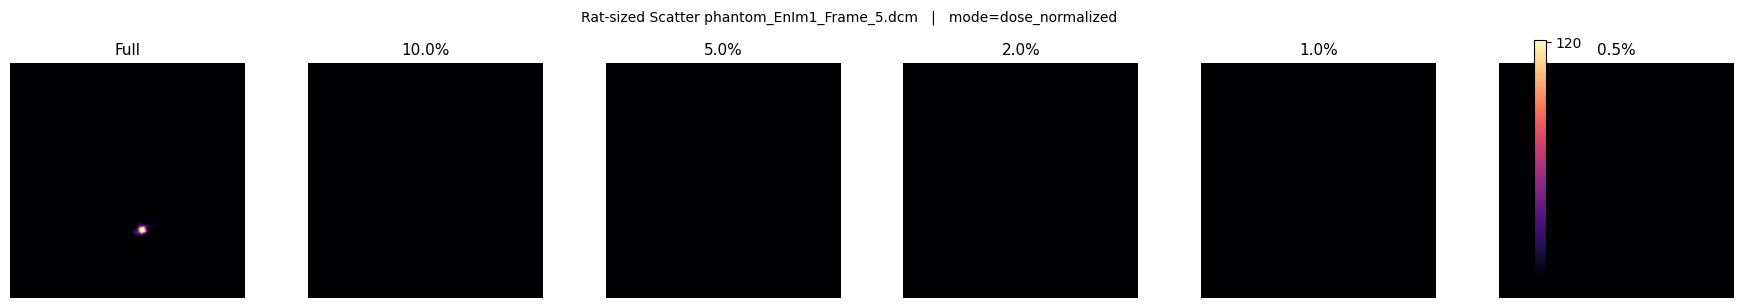

Viewing: Three rod phantom_EnIm1_Frame_271.dcm


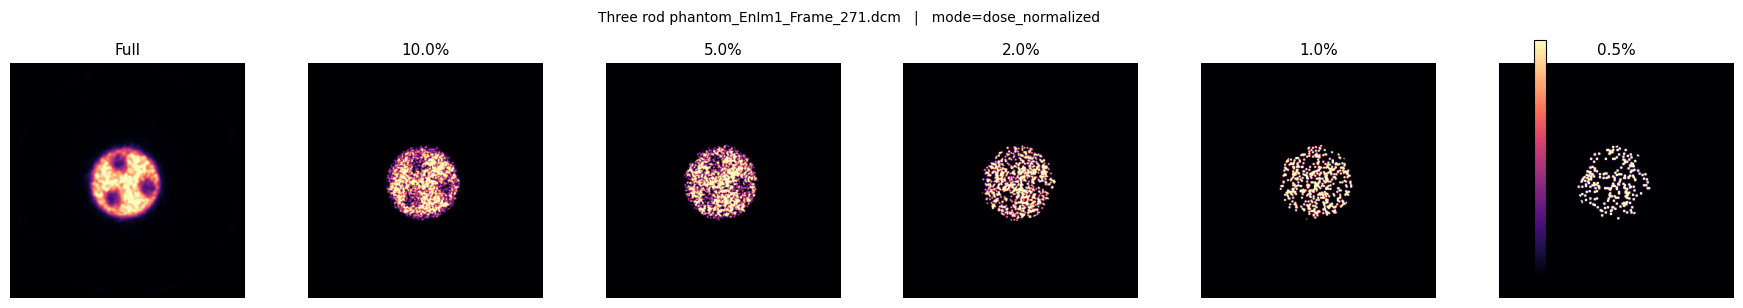

Viewing: Mouse shaped phantom_EnIm1_Frame_307.dcm


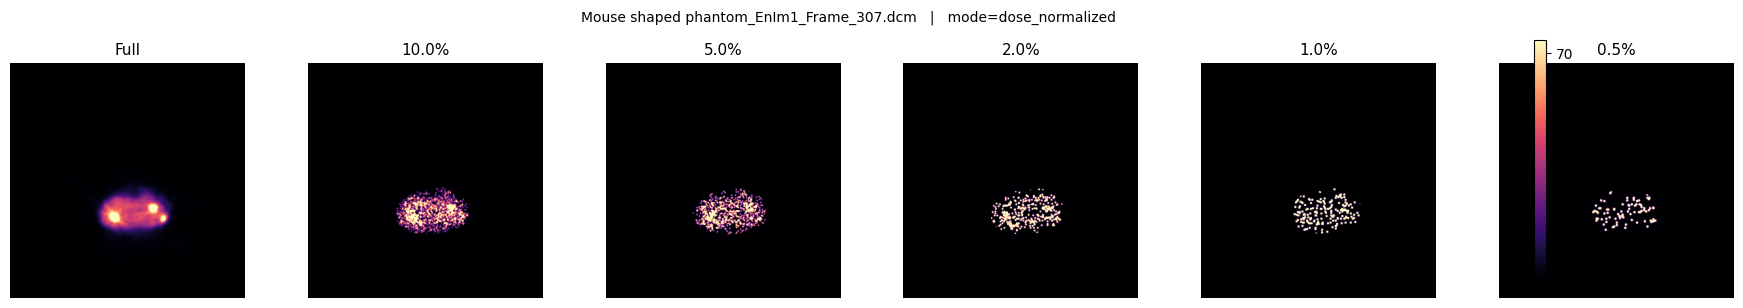

Viewing: Mouse-sized Scatter phantom_EnIm1_Frame_72.dcm


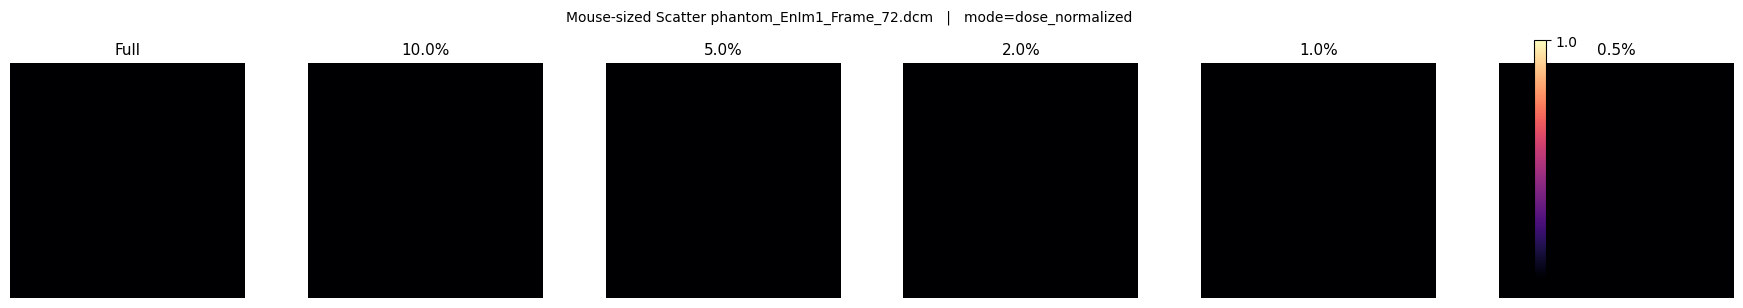

Viewing: Mouse-sized Derenzo phantom_EnIm1_Frame_325.dcm


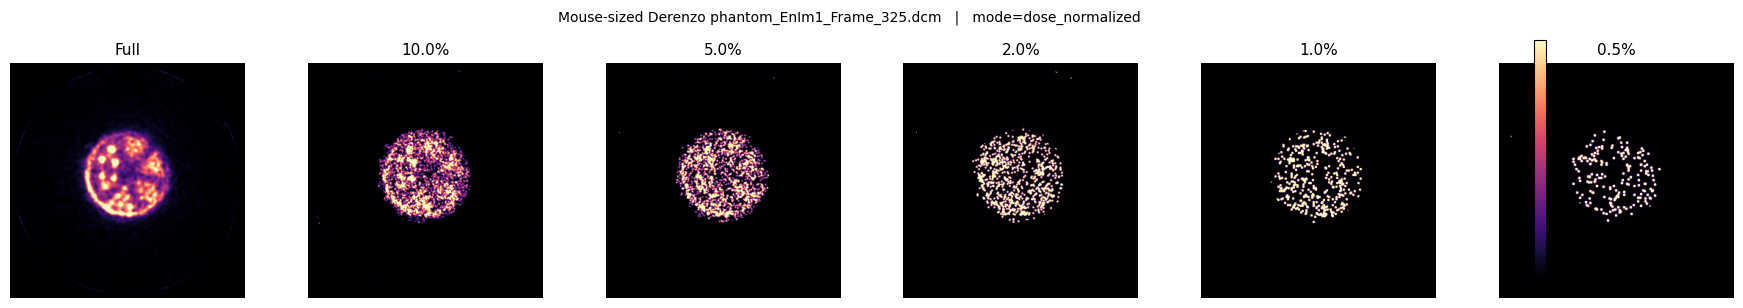

Viewing: Real small animal (Rat)_EnIm1_PET_Frame_496.dcm


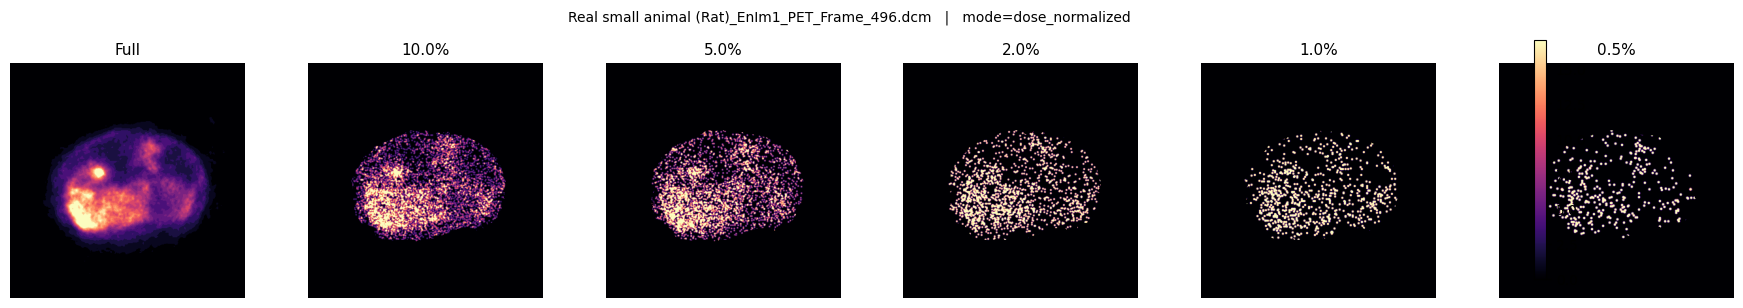

In [28]:
# --- Random side-by-side panels (new picks every run) ---
# Shows: Full dose + all synthesized doses in ALPHAS
# Mode options: "dose_normalized" | "shared" | "per_image"

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random

# ---- tweak these if you want ----
N_RANDOM  = 6
VIEW_MODE = "dose_normalized"   # "shared" | "per_image" | "dose_normalized"
PCTL_MAX  = 98.0
CMAP      = "magma"

# Fallbacks if not defined above
try:
    INPUT_DIR
except NameError:
    INPUT_DIR = Path(r"D:\Jack station\Combined_High_Dose_Images") 
try:
    OUTPUT_ROOT
except NameError:
    OUTPUT_ROOT = Path(r"D:\Jack station\low_dose_dicoms_out")
try:
    ALPHAS
except NameError:
    ALPHAS = [0.10, 0.05, 0.02, 0.01, 0.005]

# ---- minimal helpers (reuse your earlier ones if present) ----
def _body_mask(img):
    x = np.clip(img, 0, None)
    vals = x[x > 0]
    if vals.size == 0: 
        return np.zeros_like(x, bool)
    from scipy.ndimage import binary_fill_holes
    thr = np.percentile(vals, 10.0)
    return binary_fill_holes(x > max(thr*0.3, 1e-6))

def _window_from_full(fd, pctl=PCTL_MAX):
    m = _body_mask(fd)
    mv = fd[m] if np.any(m) else fd
    vmin = 0.0
    vmax = float(np.percentile(mv, pctl)) if mv.size else float(np.max(fd) or 1.0)
    if not np.isfinite(vmax) or vmax <= 0:
        vmax = float(np.max(fd) or 1.0)
    return vmin, vmax

try:
    load_dicom_float
except NameError:
    import pydicom
    def load_dicom_float(path: Path):
        ds = pydicom.dcmread(path, force=True)
        try:
            arr = ds.pixel_array.astype(np.float32)
        except Exception:
            rows, cols = int(ds.Rows), int(ds.Columns)
            bits = int(getattr(ds,"BitsAllocated",16) or 16)
            rep  = int(getattr(ds,"PixelRepresentation",0) or 0)
            dt   = np.uint16 if (bits==16 and rep==0) else np.int16
            arr  = np.frombuffer(ds.PixelData, dtype=dt, count=rows*cols).reshape(rows,cols).astype(np.float32)
        if arr.ndim == 3 and arr.shape[-1] >= 3:
            r,g,b = arr[...,0], arr[...,1], arr[...,2]
            arr   = 0.2126*r + 0.7152*g + 0.0722*b
        slope = float(getattr(ds,"RescaleSlope",1.0) or 1.0)
        inter = float(getattr(ds,"RescaleIntercept",0.0) or 0.0)
        img = slope*arr + inter
        img[~np.isfinite(img)] = 0.0
        return np.clip(img, 0, None).astype(np.float32), ds

def reload_dicom_float(path: Path):
    import pydicom
    ds = pydicom.dcmread(path, force=True)
    arr = ds.pixel_array.astype(np.float32)
    img = float(getattr(ds,"RescaleSlope",1.0) or 1.0)*arr + float(getattr(ds,"RescaleIntercept",0.0) or 0.0)
    return np.clip(img, 0, None).astype(np.float32)

def show_panel_for_file(p_full: Path, mode=VIEW_MODE, cmap=CMAP, pctl=PCTL_MAX):
    fd, _ = load_dicom_float(p_full)
    vmin, vmax = _window_from_full(fd, pctl=pctl)

    panels = [("Full", 1.0, fd)]
    for a in ALPHAS:
        rp = OUTPUT_ROOT / f"alpha_{int(round(a*1000)):03d}p" / f"{p_full.stem}_uldl_{int(round(a*1000)):03d}p.dcm"
        img = reload_dicom_float(rp) if rp.exists() else None
        panels.append((f"{a*100:.1f}%" if img is not None else f"{a*100:.1f}% (missing)", a, img))

    n = len(panels)
    fig, axes = plt.subplots(1, n, figsize=(3.0*n, 3.1))
    if n == 1: axes = [axes]
    last = None
    body = _body_mask(fd)

    for ax, (lab, a, im) in zip(axes, panels):
        if im is None:
            ax.set_facecolor("black")
            ax.text(0.5, 0.5, lab, color="w", ha="center", va="center")
            ax.axis("off")
            continue
        if mode == "dose_normalized" and a != 1.0:
            disp, vmin_j, vmax_j = im / max(a, 1e-8), vmin, vmax
        elif mode == "per_image":
            mv = im[body] if np.any(body) else im
            vmin_j, vmax_j = 0.0, float(np.percentile(mv, pctl)) if mv.size else float(np.max(im) or 1.0)
            disp = im
        else:
            disp, vmin_j, vmax_j = im, vmin, vmax
        last = ax.imshow(disp, cmap=cmap, vmin=vmin_j, vmax=vmax_j)
        ax.set_title(lab, fontsize=11)
        ax.axis("off")

    if last is not None:
        fig.colorbar(last, ax=axes, fraction=0.025, pad=0.02)
    fig.suptitle(f"{p_full.name}   |   mode={mode}", y=0.98, fontsize=10)
    fig.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# --- pick NEW random files every run (no fixed seed) ---
all_full = sorted([p for p in INPUT_DIR.rglob("*") if p.is_file() and p.suffix.lower() in (".dcm","")])
assert all_full, f"No DICOMs in {INPUT_DIR}"

sysrand = random.SystemRandom()  # uses OS entropy; different each run
pick = sysrand.sample(all_full, k=min(N_RANDOM, len(all_full)))

print(f"Showing {len(pick)} random cases from: {INPUT_DIR}")
for p in pick:
    print("Viewing:", p.name)
    show_panel_for_file(p, mode=VIEW_MODE, cmap=CMAP, pctl=PCTL_MAX)
